In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 30
pd.options.display.max_columns = 60

In [2]:
# !pip install shap
# !pip install lightgbm

In [3]:
df = pd.read_csv('match_data.csv')
df = df[df['league']=='LCK'].copy()
df.reset_index(drop=True, inplace=True)
columns = list(df.columns)

In [4]:
df.shape

(5868, 121)

In [5]:
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,side,position,playername,playerid,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,...,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01/1690520,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2021,Spring,0,2021-01-13 07:00:34,1,11.01,1,Blue,top,Rascal,oe:player:9daf04bfd9c8815cc827414f59f45af,Gen.G,oe:team:50f58982d91a36557ec8aec52ab014f,Camille,Samira,Akali,Olaf,Lucian,Kennen,2177,1,10,1,3,19,8,...,3913.0,5116.0,84.0,3279.0,4768.0,92.0,634.0,348.0,-8.0,2.0,0.0,0.0,0.0,0.0,2.0,6236.0,8357.0,122.0,4688.0,6893.0,130.0,1548.0,1464.0,-8.0,3.0,1.0,0.0,0.0,0.0,4.0
1,ESPORTSTMNT01/1690520,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2021,Spring,0,2021-01-13 07:00:34,1,11.01,2,Blue,jng,Clid,oe:player:d3abb04a273ed8615be5f54a391818e,Gen.G,oe:team:50f58982d91a36557ec8aec52ab014f,Taliyah,Samira,Akali,Olaf,Lucian,Kennen,2177,1,2,3,8,19,8,...,3536.0,4323.0,77.0,3369.0,3950.0,77.0,167.0,373.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5738.0,6947.0,122.0,4835.0,5942.0,110.0,903.0,1005.0,12.0,1.0,3.0,1.0,0.0,0.0,0.0
2,ESPORTSTMNT01/1690520,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2021,Spring,0,2021-01-13 07:00:34,1,11.01,3,Blue,mid,Bdd,oe:player:30361653a485a9609fb2d3aa073282c,Gen.G,oe:team:50f58982d91a36557ec8aec52ab014f,Yone,Samira,Akali,Olaf,Lucian,Kennen,2177,1,2,1,8,19,8,...,3321.0,4862.0,90.0,3605.0,5064.0,104.0,-284.0,-202.0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,5467.0,7762.0,147.0,5728.0,7987.0,167.0,-261.0,-225.0,-20.0,1.0,1.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT01/1690520,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2021,Spring,0,2021-01-13 07:00:34,1,11.01,4,Blue,bot,Ruler,oe:player:eada4723af6f51cf2391d85b5fde49b,Gen.G,oe:team:50f58982d91a36557ec8aec52ab014f,Jhin,Samira,Akali,Olaf,Lucian,Kennen,2177,1,4,1,6,19,8,...,3151.0,3084.0,82.0,3429.0,3727.0,87.0,-278.0,-643.0,-5.0,0.0,0.0,0.0,0.0,1.0,0.0,5393.0,6129.0,141.0,5437.0,6334.0,145.0,-44.0,-205.0,-4.0,0.0,2.0,0.0,0.0,1.0,0.0
4,ESPORTSTMNT01/1690520,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2021,Spring,0,2021-01-13 07:00:34,1,11.01,5,Blue,sup,Life,oe:player:dea5251e486aed942e1bc06e1d5c116,Gen.G,oe:team:50f58982d91a36557ec8aec52ab014f,Sett,Samira,Akali,Olaf,Lucian,Kennen,2177,1,1,2,7,19,8,...,2083.0,2476.0,16.0,2243.0,2276.0,10.0,-160.0,200.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,3198.0,2855.0,22.0,3253.0,3113.0,16.0,-55.0,-258.0,6.0,1.0,0.0,0.0,1.0,0.0,2.0


In [6]:
summary_df = df.copy()

summary_df['killsdiffat15'] = summary_df['killsat15'] - summary_df['opp_killsat15']
summary_df['assistsdiffat15'] = summary_df['assistsat15'] - summary_df['opp_assistsat15']
summary_df['deathsdiffat15'] = summary_df['deathsat15'] - summary_df['opp_deathsat15']

summary_col_list = ['playername','position',
 'golddiffat15','xpdiffat15','csdiffat15',
 'killsdiffat15','assistsdiffat15','deathsdiffat15',
 'damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle','firstblood',
 'firstdragon','dragons','elders','firstherald',
 'heralds','firstbaron','barons','firsttower','towers',
 'result']

time_col_list = ['damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle']

for col in time_col_list:
    summary_df[col] = summary_df[col]/summary_df['gamelength']

summary_df = summary_df[summary_col_list].copy()

In [8]:
top_df = summary_df[summary_df['position']=='top'].copy()
top_df = top_df.drop(columns=['position'])
top_df = top_df.reset_index(drop=True)
top_df = top_df.dropna(axis=1)

mid_df = summary_df[summary_df['position']=='mid'].copy()
mid_df = mid_df.drop(columns=['position'])
mid_df = mid_df.reset_index(drop=True)
mid_df = mid_df.dropna(axis=1)

jng_df = summary_df[summary_df['position']=='jng'].copy()
jng_df = jng_df.drop(columns=['position'])
jng_df = jng_df.reset_index(drop=True)
jng_df = jng_df.dropna(axis=1)

bot_df = summary_df[summary_df['position']=='bot'].copy()
bot_df = bot_df.drop(columns=['position'])
bot_df = bot_df.reset_index(drop=True)
bot_df = bot_df.dropna(axis=1)

sup_df = summary_df[summary_df['position']=='sup'].copy()
sup_df = sup_df.drop(columns=['position'])
sup_df = sup_df.reset_index(drop=True)
sup_df = sup_df.dropna(axis=1)

team_df = summary_df[summary_df['position']=='team'].copy()
team_df = team_df.drop(columns=['position'])
team_df = team_df.reset_index(drop=True)
team_df = team_df.dropna(axis=1)

In [9]:
top_df

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood,result
0,Rascal,1548.0,1464.0,-8.0,3.0,1.0,-4.0,10.228296,0.000157,0.349910,0.005053,0.011024,0.003675,0.023886,8.448323,0.153881,0.023886,1.0,1
1,Doran,-1548.0,-1464.0,8.0,-3.0,-1.0,4.0,5.097382,0.000091,0.211967,0.010106,0.003215,0.005053,0.014240,4.858521,0.114837,0.000000,0.0,0
2,Doran,-725.0,-117.0,-4.0,-1.0,-2.0,1.0,11.943889,0.000175,0.486796,0.007778,0.001667,0.002222,0.012778,5.923889,0.141667,0.005556,0.0,0
3,Rascal,725.0,117.0,4.0,1.0,2.0,-1.0,8.475000,0.000126,0.494778,0.005000,0.002222,0.002778,0.010000,7.975556,0.154444,0.008889,0.0,1
4,Canna,-152.0,420.0,-14.0,0.0,1.0,-1.0,3.866955,0.000101,0.269147,0.005408,0.001622,0.002704,0.012980,6.266631,0.131963,0.005949,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,Morgan,-1317.0,-757.0,5.0,-3.0,1.0,1.0,5.186653,0.000083,0.246266,0.007025,0.004516,0.004516,0.021576,7.070748,0.155043,0.015053,1.0,1
974,Canna,8.0,-363.0,7.0,-1.0,0.0,1.0,9.268569,0.000133,0.178070,0.004982,0.004076,0.003623,0.018569,6.259964,0.124547,0.012681,0.0,0
975,Morgan,-8.0,363.0,-7.0,1.0,0.0,-1.0,8.042120,0.000105,0.427263,0.006793,0.003623,0.004982,0.014946,7.556159,0.142210,0.006341,0.0,1
976,Morgan,-98.0,-8.0,-22.0,1.0,1.0,-2.0,4.169006,0.000083,0.319411,0.007861,0.005615,0.005615,0.022459,6.075239,0.122965,0.008984,1.0,0


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def encoder(df):
    le = LabelEncoder()
    labels = le.fit_transform(df.iloc[:,0])
    df.iloc[:,0] = labels
    return df

top_df = encoder(top_df)
mid_df = encoder(mid_df)
jng_df = encoder(jng_df)
bot_df = encoder(bot_df)
sup_df = encoder(sup_df)

def scaler(df):
    scaler = MinMaxScaler()
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    return df

top_df = scaler(top_df)
mid_df = scaler(mid_df)
jng_df = scaler(jng_df)
bot_df = scaler(bot_df)
sup_df = scaler(sup_df)

In [11]:
top_df

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood,result
0,10,0.722478,0.822894,0.437500,0.8,0.583333,0.1,0.521206,0.472512,0.220937,0.204099,0.760680,0.430409,0.536071,0.830052,0.730708,0.533713,1.0,1.0
1,3,0.277522,0.177106,0.562500,0.2,0.416667,0.9,0.201437,0.228361,0.105037,0.576940,0.221865,0.591812,0.221209,0.136630,0.401615,0.000000,0.0,0.0
2,3,0.395803,0.474195,0.468750,0.4,0.333333,0.6,0.628125,0.538526,0.335949,0.405170,0.115000,0.260278,0.173488,0.342421,0.627753,0.124134,0.0,0.0
3,10,0.604197,0.525805,0.531250,0.6,0.666667,0.4,0.411937,0.354955,0.342655,0.200201,0.153333,0.325347,0.082820,0.738730,0.735453,0.198614,0.0,1.0
4,1,0.478155,0.592633,0.390625,0.5,0.583333,0.4,0.124754,0.265353,0.153080,0.230331,0.111952,0.316725,0.180088,0.408627,0.545966,0.132929,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,9,0.310721,0.333039,0.539062,0.2,0.583333,0.6,0.207000,0.197505,0.133855,0.349593,0.311591,0.528914,0.460652,0.563954,0.740495,0.336338,1.0,1.0
974,1,0.501150,0.419938,0.554688,0.4,0.500000,0.6,0.461394,0.381482,0.076558,0.198864,0.281250,0.424366,0.362512,0.407339,0.483458,0.283349,0.0,0.0
975,9,0.498850,0.580062,0.445312,0.6,0.500000,0.4,0.384959,0.280608,0.285929,0.332539,0.250000,0.583503,0.244249,0.657718,0.632334,0.141674,0.0,1.0
976,9,0.485915,0.498236,0.328125,0.6,0.583333,0.3,0.143578,0.198978,0.195312,0.411292,0.387423,0.657636,0.489499,0.371657,0.470120,0.200733,1.0,0.0


In [12]:
# pip install lightgbm

In [13]:
top_df.drop(columns=['result'])

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood
0,10,0.722478,0.822894,0.437500,0.8,0.583333,0.1,0.521206,0.472512,0.220937,0.204099,0.760680,0.430409,0.536071,0.830052,0.730708,0.533713,1.0
1,3,0.277522,0.177106,0.562500,0.2,0.416667,0.9,0.201437,0.228361,0.105037,0.576940,0.221865,0.591812,0.221209,0.136630,0.401615,0.000000,0.0
2,3,0.395803,0.474195,0.468750,0.4,0.333333,0.6,0.628125,0.538526,0.335949,0.405170,0.115000,0.260278,0.173488,0.342421,0.627753,0.124134,0.0
3,10,0.604197,0.525805,0.531250,0.6,0.666667,0.4,0.411937,0.354955,0.342655,0.200201,0.153333,0.325347,0.082820,0.738730,0.735453,0.198614,0.0
4,1,0.478155,0.592633,0.390625,0.5,0.583333,0.4,0.124754,0.265353,0.153080,0.230331,0.111952,0.316725,0.180088,0.408627,0.545966,0.132929,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,9,0.310721,0.333039,0.539062,0.2,0.583333,0.6,0.207000,0.197505,0.133855,0.349593,0.311591,0.528914,0.460652,0.563954,0.740495,0.336338,1.0
974,1,0.501150,0.419938,0.554688,0.4,0.500000,0.6,0.461394,0.381482,0.076558,0.198864,0.281250,0.424366,0.362512,0.407339,0.483458,0.283349,0.0
975,9,0.498850,0.580062,0.445312,0.6,0.500000,0.4,0.384959,0.280608,0.285929,0.332539,0.250000,0.583503,0.244249,0.657718,0.632334,0.141674,0.0
976,9,0.485915,0.498236,0.328125,0.6,0.583333,0.3,0.143578,0.198978,0.195312,0.411292,0.387423,0.657636,0.489499,0.371657,0.470120,0.200733,1.0


In [14]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

ftr = jng_df.drop(columns=['result'])
target = jng_df.result

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_warpper = LGBMClassifier(verbose=0)

evals = [(X_test, y_test)]
lgbm_warpper.fit(X_train, y_train, early_stopping_rounds = 100,
                eval_metric='logloss', eval_set = evals, verbose = True)
preds = lgbm_warpper.predict(X_test)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.641214
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.598352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.563926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.535652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.508897
[6]	valid_0's binary_logloss: 0.487609
[Lig

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lgbm_warpper, ftr, target, scoring = 'accuracy', cv=5)
print('교차 검증 정확도 : {}'.format(sum(scores/5)))

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

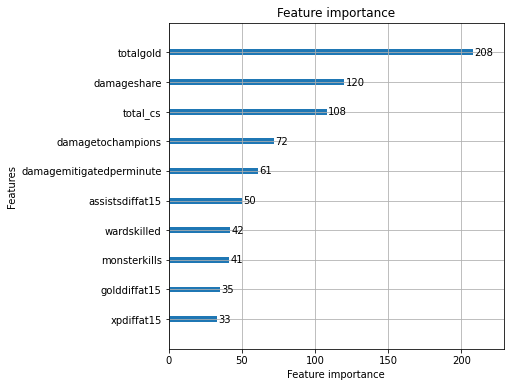

In [16]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
# feature_importance 이외에도 importance를 구하는 방법 찾기

f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_warpper, max_num_features=10, ax=ax)

<AxesSubplot:title={'center':'Person Correlation of Features'}>

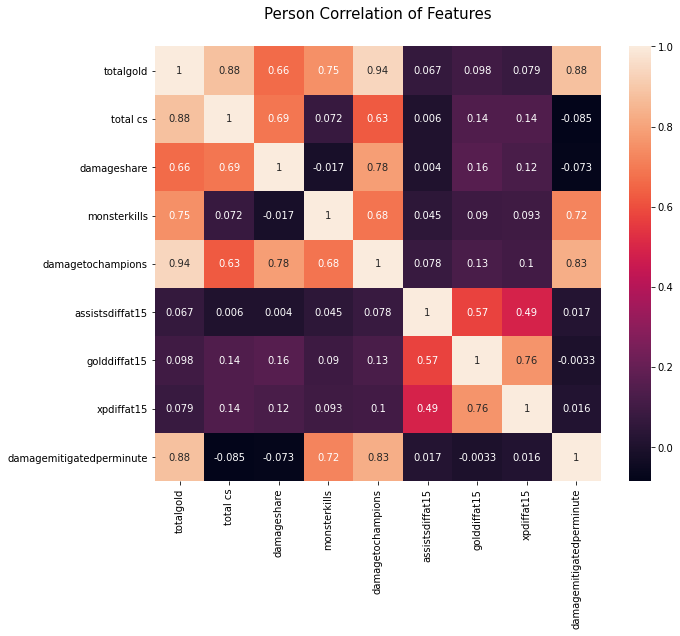

In [17]:
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(summary_df[['totalgold','total cs', 'damageshare', 'monsterkills', 'damagetochampions', 'assistsdiffat15', \
    'golddiffat15', 'xpdiffat15', 'damagemitigatedperminute']].corr(), annot=True)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


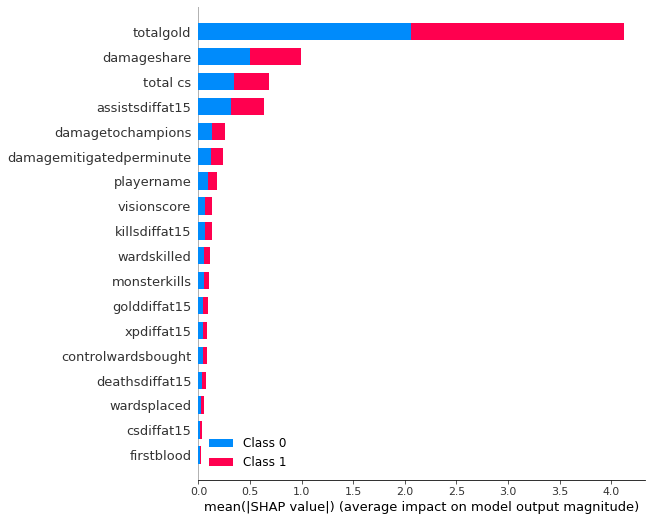

In [18]:
import shap
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

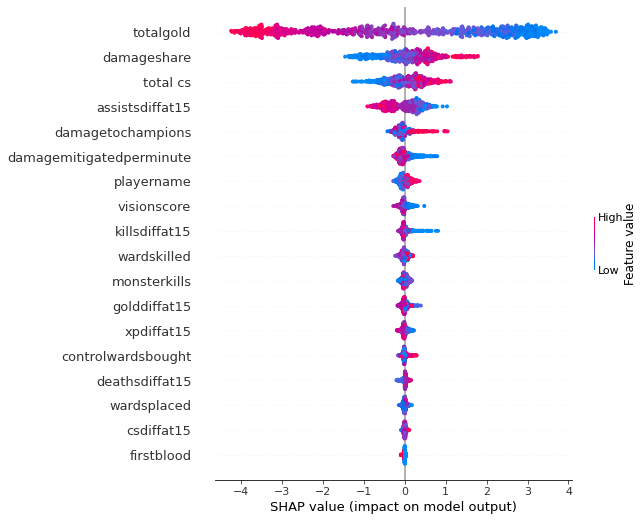

In [19]:
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)